In [1]:
from typing import Iterable, List, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn

### Paremeters of the distributions; $\pi_0, \pi_1$

In [2]:
# def sample_along_circle(num_locations: int, radius: float = 1.0):
#     """Sample evenly-spaced 2d locations along a circle with a given radius.

#     Args:
#         num_locations: number of locations to sample.
#         radius: radius of the circle.
#     """
#     dtheta = 2 * np.pi / num_locations
#     locations = []
#     for i in range(num_locations):
#         theta = i * dtheta
#         locations.append([radius * np.cos(theta), radius * np.sin(theta)])
#     return locations

# var0 = 0.1
# var1 = 0.3
# locations = sample_along_circle(6, radius=10.0)
# locations0 = locations[::2]
# locations1 = locations[1::2]
# num_samples = 100

In [3]:
var0 = 0.1
var1 = 0.3
locations0 = [(0, 0), (0, 10)]
locations1 = [(10, 0), (10, 10)]
num_samples = 100

### *Utility methods*
1. **Sample from a mixture of gaussians.**
2. **Scatter plot 2d points.**

In [4]:
def sample_gaussian_mixture_model(locations: np.ndarray, variances: Union[float, np.ndarray], num_samples: int) -> torch.Tensor:
    """
    Sample from a mixture of Gaussians.

    This function generates samples from a mixture of Gaussian distributions 
    specified by their means (locations) and variances.

    Args:
        locations (np.ndarray): An array of Gaussian means with shape (L, 2), 
                                where L is the number of Gaussians.
        variances (Union[float, np.ndarray]): An array of Gaussian variances with shape (L,), 
                                              or a single float to be used for all Gaussians.
        num_samples (int): The number of samples to generate.

    Returns:
        torch.Tensor: A tensor containing the generated samples with shape (num_samples, 2).

    Example:
        >>> locations = np.array([[0, 0], [1, 1], [2, 2]])
        >>> variances = np.array([0.1, 0.2, 0.3])
        >>> num_samples = 90
        >>> samples = sample_gaussian_mixture_model(locations, variances, num_samples)
        >>> print(samples.shape)  # Output: torch.Size([90, 2])
    """
    num_gaussians = len(locations)
    if isinstance(variances, float):
        variances = [variances] * num_gaussians

    num_samples_pre_gaussian = num_samples // num_gaussians
    pi = np.concatenate([
        np.random.multivariate_normal(mean=loc,
                                      cov=np.sqrt(var) * np.eye(2),
                                      size=(num_samples_pre_gaussian,)) for loc, var in zip(locations, variances)
    ], axis=0)
    np.random.shuffle(pi)
    return torch.tensor(pi).float()


def draw_points2d(*points2d, labels: Iterable[str] = None):
    """
    Scatter plot 2D points.

    This function generates scatter plots for any number of 2D points. Each set 
    of points can optionally be labeled.

    Args:
        points2d: Any number of 2D points to scatter. Each argument should be an 
                  array-like object with shape (N, 2), where N is the number of points.
        labels (Iterable[str], optional): An iterable of strings to label each plot. 
                                          The length of labels should match the number 
                                          of `points2d` provided.

    Returns:
        None

    Example:
        >>> points1 = np.random.rand(100, 2)
        >>> points2 = np.random.rand(100, 2) + 1
        >>> draw_points2d(points1, points2, labels=['Set 1', 'Set 2'])
    """
    num_scatters = len(points2d)
    if labels is None:
        labels = [f"$p_{i}$" for i in range(num_scatters)]
    colors = sns.color_palette("pastel", num_scatters)
    _, ax = plt.subplots()
    for i, p in enumerate(points2d):
        ax.scatter(x=p[:, 0], y=p[:, 1], color=colors[i], alpha=0.5, label=labels[i])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.grid(True)
    ax.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, 1.2),
        ncol=2,
        fancybox=True,
        shadow=True,
    );

### Create two distributions; $\pi_0, \pi_1$ and display them

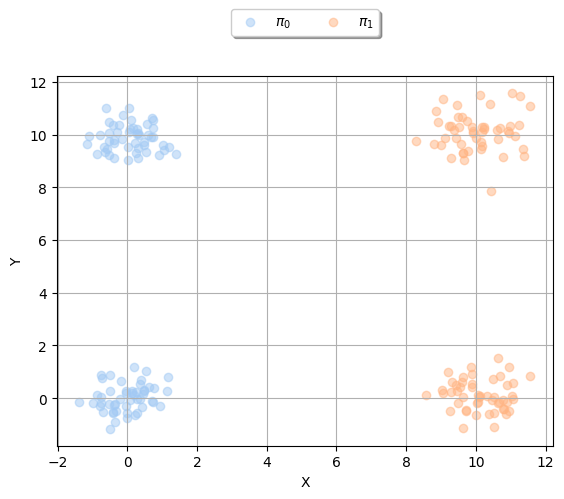

In [5]:
pi0 = sample_gaussian_mixture_model(locations0, variances=var0, num_samples=num_samples)
pi1 = sample_gaussian_mixture_model(locations1, variances=var1, num_samples=num_samples)
draw_points2d(pi0, pi1, labels=("$\pi_0$", "$\pi_1$"));

### *Utility methods:*
1. **Simple MLP to estimate the flow field.**
2. **Sample the trajectories along the flow field predicted by a given model.**
3. **Scatter plot 2d trajectories of points flowing according the flow field.**

In [6]:
def simple_mlp(hidden_features: List[int] = [100, 100, 100, 100, 100]) -> nn.Sequential:
    """
    Simple MLP to estimate the flow field.

    This function constructs a simple Multi-Layer Perceptron (MLP) architecture 
    designed to estimate the flow field from input data. The MLP consists of 
    several hidden linear layers with specified numbers of neurons in each layer.

    Args:
        hidden_features (List[int]): A list of integers where each integer 
                                     represents the number of neurons in a hidden layer.
                                     Default is [100, 100, 100, 100, 100].

    Returns:
        nn.Sequential: The constructed MLP model as a PyTorch `nn.Sequential` module.

    Example:
        >>> hidden_layers = [128, 128, 64, 64]
        >>> model = simple_mlp(hidden_layers)
        >>> print(model)
    """
    def _layer(f_out):
        return nn.Sequential(nn.LazyLinear(out_features=f_out), nn.Tanh())
    hidden_layers = [_layer(f_out) for f_out in hidden_features]
    return nn.Sequential(*hidden_layers, nn.LazyLinear(out_features=2))


def sample_ode(model: nn.Module, x0: torch.Tensor, num_steps: int) -> torch.Tensor:
    """
    Sample the trajectories along the flow field predicted by a given model.

    This function samples the trajectories of points as they move along the 
    flow field predicted by the provided model. Starting from the initial 
    points `x0`, it iteratively predicts the velocity field to compute the 
    positions at each step.

    Args:
        model: The model used to predict the velocity field.
        x0 (numpy.ndarray): The starting points of the trajectories.
        num_steps (int): Number of steps to sample.

    Returns:
        numpy.ndarray: The sampled trajectories with shape (num_steps+1, num_points, 2).
                       The first location is always `x0`, and the last location is a point 
                       from the generated target distribution.

    Example:
        >>> model = simple_mlp()
        >>> x0 = np.random.rand(10, 2)
        >>> num_steps = 100
        >>> trajectories = sample_trajectories(model, x0, num_steps)
    """
    batch_size = x0.shape[0]
    dt = x0.new_ones(size=(batch_size, 1)) / num_steps
    trajectories = x0.new_empty(size=[num_steps+1, batch_size, 2])
    cur_z = x0.clone()  # starting from x0
    trajectories[0] = cur_z
    for step in range(1, num_steps + 1):
        cur_t = dt * step
        cur_inp = torch.cat([cur_z, cur_t], dim=1)
        pred = model(cur_inp)
        cur_z += pred * dt
        trajectories[step] = cur_z
    return trajectories


def draw_trajectories2d(trajectories: np.ndarray, *, linestyle="-", linewidth=2, marker="o", markersize=2):
    """
    Plot 2D trajectories of points flowing according to the flow field.

    This function generates a scatter plot for the 2D trajectories of points 
    moving along a flow field. Each point's trajectory is plotted with a 
    distinct color.

    Args:
        trajectories (numpy.ndarray): Array with shape (num_steps, num_points, 2) 
                                      representing the 2D points along the flow field.
                                      - num_steps: Number of time steps.
                                      - num_points: Number of points.
                                      - 2: X and Y coordinates of each point.

    Example:
        >>> import numpy as np
        >>> trajectories = np.random.rand(100, 10, 2)
        >>> draw_trajectories2d(trajectories)
    """
    num_steps, num_points, _ = trajectories.shape
    colors = sns.color_palette("pastel", num_points)
    _, ax = plt.subplots()
    for p in range(num_points):
        for t in range(1, num_steps):
            ax.plot([trajectories[t-1, p, 0], trajectories[t, p, 0]],
                    [trajectories[t-1, p, 1], trajectories[t, p, 1]],
                    color=colors[p], 
                    linestyle=linestyle,
                    linewidth=linewidth, 
                    marker=marker,
                    markersize=markersize, 
                    alpha=0.5)
            
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.grid(True)

/Users/nitai/mambaforge/envs/cmm/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


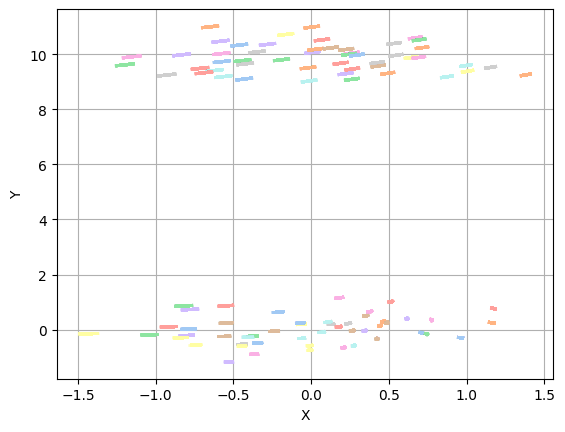

In [7]:
# instantiate a model
model = simple_mlp()
model.to("mps");

# sample trajectroeis from the untrained model
num_steps = 500
trajectories = sample_ode(model, pi0.to("mps"), num_steps)
trajectories = trajectories.detach().cpu().numpy()

# show the trajectories
draw_trajectories2d(trajectories, linewidth=2, marker=None);

### *Utility method:* **prepare a training example**

In [8]:
def prepare_training_sample(x0: torch.Tensor, x1: torch.Tensor) -> torch.Tensor:
    """
    Prepare a training sample from points in source and target distributions.

    This function prepares a training sample using 2D points from a source 
    distribution and a target distribution. Both sets of points are assumed 
    to have the same shape and represent corresponding locations in their 
    respective distributions.

    Args:
        x0 (torch.Tensor): 2D points from the source distribution with shape (N, 2).
        x1 (torch.Tensor): 2D points from the target distribution with shape (N, 2).

    Returns:
        Tuple[torch.Tensor, torch.Tensor]: A tuple containing the source and target points.
                                            - The first element is the tensor of source points.
                                            - The second element is the tensor of target points.

    Example:
        >>> import torch
        >>> x0 = torch.randn(100, 2)
        >>> x1 = torch.randn(100, 2)
        >>> source_points, target_points = prepare_training_sample(x0, x1)
    """
    assert x0.shape == x1.shape
    t = torch.rand_like(x0[:, 0:1])
    zt = t * x1 + (1 - t) * x0
    return torch.cat([zt, t], dim=1)

### Train the model!

In [9]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

batch_size = 2000
num_epochs = 2000
running_loss = []
for epoch in range(num_epochs):
    optimizer.zero_grad()

    pi0 = sample_gaussian_mixture_model(locations0, variances=var0, num_samples=batch_size)
    pi1 = sample_gaussian_mixture_model(locations1, variances=var1, num_samples=batch_size)
    
    inp = prepare_training_sample(pi0, pi1)
    target = pi1 - pi0  # the linear path pointing from x0 to x1 
    
    inp = inp.to("mps")
    target = target.to("mps")
    pred = model(inp)
    
    loss = loss_fn(pred, target)
    running_loss.append(loss.item())

    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Loss[{epoch+1:5d}/{num_epochs:5d}]: {running_loss[-1]}')

/Users/nitai/mambaforge/envs/cmm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loss[  100/ 2000]: 24.81856918334961
Loss[  200/ 2000]: 24.378929138183594
Loss[  300/ 2000]: 26.6263370513916
Loss[  400/ 2000]: 26.403587341308594
Loss[  500/ 2000]: 25.7723388671875
Loss[  600/ 2000]: 25.996797561645508
Loss[  700/ 2000]: 26.0772647857666
Loss[  800/ 2000]: 25.177959442138672
Loss[  900/ 2000]: 25.871225357055664
Loss[ 1000/ 2000]: 24.85152816772461
Loss[ 1100/ 2000]: 25.804670333862305
Loss[ 1200/ 2000]: 25.46932601928711
Loss[ 1300/ 2000]: 13.810120582580566
Loss[ 1400/ 2000]: 9.032943725585938
Loss[ 1500/ 2000]: 8.938090324401855
Loss[ 1600/ 2000]: 7.800581455230713
Loss[ 1700/ 2000]: 8.057392120361328
Loss[ 1800/ 2000]: 7.825883388519287
Loss[ 1900/ 2000]: 7.96148157119751
Loss[ 2000/ 2000]: 8.283346176147461


### Sample trajectories with the trained model

In [10]:
num_steps = 500
num_points = 100
pi0 = sample_gaussian_mixture_model(locations0, variances=var0, num_samples=num_points)
pi1 = sample_gaussian_mixture_model(locations1, variances=var1, num_samples=num_points)
trajectories = sample_ode(model, pi0.to("mps"), num_steps).detach().cpu().numpy()
gen_pi1 = trajectories[-1]

### Display the generate points and the trajectories

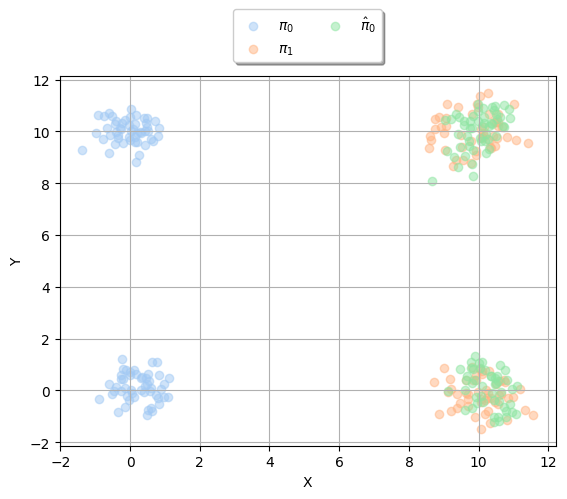

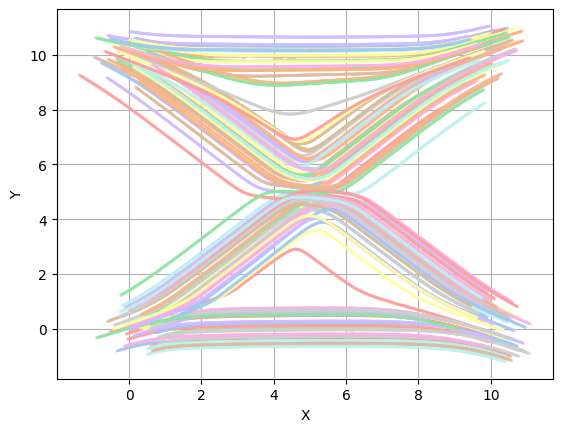

In [11]:
draw_points2d(pi0.numpy(), pi1.numpy(), gen_pi1, labels=("$\pi_0$", "$\pi_1$", "$\hat{\pi}_0$"));
draw_trajectories2d(trajectories, linewidth=2, marker=None);

### ReFlow!

In [13]:
reflow_model = simple_mlp()
reflow_model.to("mps")

# train the model
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(reflow_model.parameters(), lr=1e-3)

batch_size = 64
num_epochs = 2000
num_steps = 500
running_loss = []
for epoch in range(num_epochs):
    optimizer.zero_grad()

    pi0 = sample_gaussian_mixture_model(locations0, variances=var0, num_samples=batch_size)
    pi0 = pi0.to("mps")
    # use the previously trained model to get pi1
    # trajectories = sample_ode(model, pi0, num_steps)
    trajectories = sample_ode(model, pi0, num_steps).detach()
    gen_pi1 = trajectories[-1]
    
    inp = prepare_training_sample(pi0, gen_pi1)
    target = gen_pi1 - pi0  # the linear path pointing from x0 to x1 
    
    pred = reflow_model(inp)
    
    loss = loss_fn(pred, target)
    running_loss.append(loss.item())

    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Loss[{epoch+1:5d}/{num_epochs:5d}]: {running_loss[-1]}')

Loss[  100/ 2000]: 0.4715232253074646
Loss[  200/ 2000]: 2.523798942565918
Loss[  300/ 2000]: 0.14294929802417755
Loss[  400/ 2000]: 1.3218069076538086
Loss[  500/ 2000]: 0.9075130224227905
Loss[  600/ 2000]: 0.16915363073349
Loss[  700/ 2000]: 1.2983016967773438
Loss[  800/ 2000]: 1.681710124015808
Loss[  900/ 2000]: 0.5040969848632812
Loss[ 1000/ 2000]: 0.5527329444885254
Loss[ 1100/ 2000]: 1.7169017791748047
Loss[ 1200/ 2000]: 0.5252110362052917
Loss[ 1300/ 2000]: 0.471065491437912
Loss[ 1400/ 2000]: 0.7724874019622803
Loss[ 1500/ 2000]: 1.3179926872253418
Loss[ 1600/ 2000]: 0.9132530689239502
Loss[ 1700/ 2000]: 1.385581374168396
Loss[ 1800/ 2000]: 0.9572826623916626
Loss[ 1900/ 2000]: 2.4153034687042236
Loss[ 2000/ 2000]: 1.2187728881835938


### Sample trajectories with the ReFlow model

In [14]:
num_steps = 500
num_points = 100
pi0 = sample_gaussian_mixture_model(locations0, variances=var0, num_samples=num_points)
pi1 = sample_gaussian_mixture_model(locations1, variances=var1, num_samples=num_points)
trajectories = sample_ode(reflow_model, pi0.to("mps"), num_steps).detach().cpu().numpy()
gen_pi1 = trajectories[-1]

### Display the generate points and the trajectories

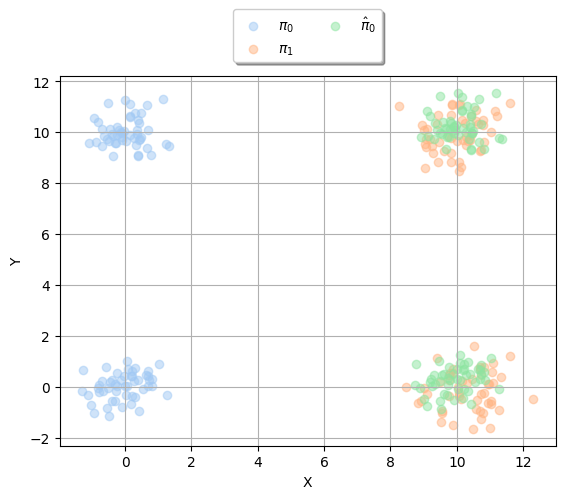

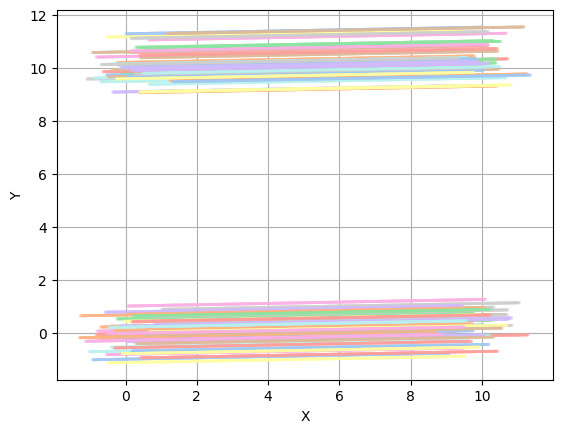

In [15]:
draw_points2d(pi0.numpy(), pi1.numpy(), gen_pi1, labels=("$\pi_0$", "$\pi_1$", "$\hat{\pi}_0$"));
draw_trajectories2d(trajectories, linewidth=2, marker=None);

### Sample trajectories with the ReFlow model with only a single Euler discretization step!

In [16]:
num_steps = 1
num_points = 100
pi0 = sample_gaussian_mixture_model(locations0, variances=var0, num_samples=num_points)
pi1 = sample_gaussian_mixture_model(locations1, variances=var1, num_samples=num_points)
trajectories = sample_ode(reflow_model, pi0.to("mps"), num_steps).detach().cpu().numpy()
gen_pi1 = trajectories[-1]

### Display the generate points and the trajectories

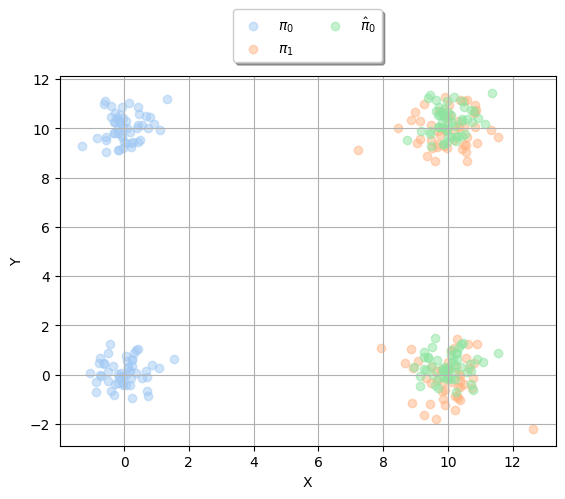

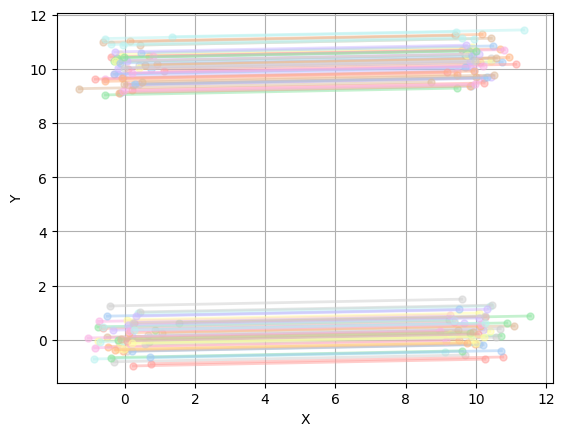

In [18]:
draw_points2d(pi0.numpy(), pi1.numpy(), gen_pi1, labels=("$\pi_0$", "$\pi_1$", "$\hat{\pi}_0$"));
draw_trajectories2d(trajectories, linewidth=2, marker="o", markersize=5);